# GOLD

In [74]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import yfinance as yf
import statsmodels.api as sm
from patsy import dmatrices

In [27]:
tickers = yf.Tickers('GLD JPY=X')
history = tickers.history(period='max', interval='1d')

gold = pl.DataFrame({
    'date': history.index,
    'value': history['Close']['GLD'] * history['Close']['JPY=X']
}).drop_nulls()
month_end = gold['date'].dt.month_end().unique()
gold = gold.filter(pl.col('date').is_in(month_end))

years = len(gold) / 12
v_first = gold['value'][0]
v_last = gold['value'][-1]
gold_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'Gold CAGR: {gold_cagr:.2%}')

gold_vol = gold['value'].log().diff().drop_nulls().std() * np.sqrt(12)
print(f'Gold Volatility: {gold_vol:.2%}')

gold_sharp_ratio = gold_cagr / gold_vol
print(f'Gold Sharp Ratio: {gold_sharp_ratio:.2f}')

gold.head()

[*********************100%***********************]  2 of 2 completed

Gold CAGR: 16.08%
Gold Volatility: 17.26%
Gold Sharp Ratio: 0.93


date,value
datetime[ns],f64
2004-11-30 00:00:00,4642.847959
2004-12-31 00:00:00,4489.938015
2005-01-31 00:00:00,4373.992062
2005-02-28 00:00:00,4550.190719
2005-03-31 00:00:00,4587.734741


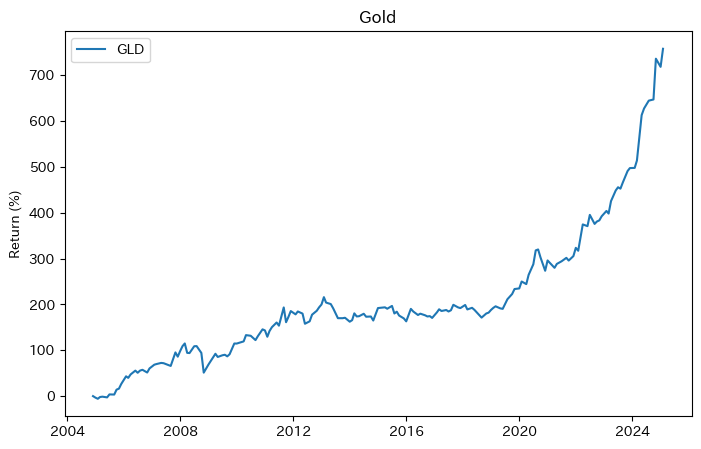

In [19]:
log_return = gold['value'].log() - gold['value'].log()[0]
gold_return = (log_return.exp() - 1) * 100

fig, ax = plt.subplots(figsize=(1.618*5, 5))
ax.plot(gold['date'], gold_return, label='GLD')
ax.set_title('Gold')
ax.set_ylabel('Return (%)')
ax.legend()

## SLV

In [25]:
tickers = yf.Tickers('SLV JPY=X')
history = tickers.history(period='max', interval='1d')

silver = pl.DataFrame({
    'date': history.index,
    'value': history['Close']['SLV'] * history['Close']['JPY=X']
}).drop_nulls()
month_end = silver['date'].dt.month_end().unique()
silver = silver.filter(pl.col('date').is_in(month_end))

years = len(silver) / 12
v_first = silver['value'][0]
v_last = silver['value'][-1]
silver_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'silver CAGR: {silver_cagr:.2%}')

silver_vol = silver['value'].log().diff().drop_nulls().std() * np.sqrt(12)
print(f'silver Volatility: {silver_vol:.2%}')

silver_sharp_ratio = silver_cagr / silver_vol
print(f'silver Sharp Ratio: {silver_sharp_ratio:.2f}')

silver.head()

[*********************100%***********************]  2 of 2 completed

silver CAGR: 8.89%
silver Volatility: 33.79%
silver Sharp Ratio: 0.26


date,value
datetime[ns],f64
2006-05-31 00:00:00,1421.028854
2006-06-30 00:00:00,1275.304079
2006-07-31 00:00:00,1307.13167
2006-08-31 00:00:00,1514.882887
2006-10-31 00:00:00,1432.77969


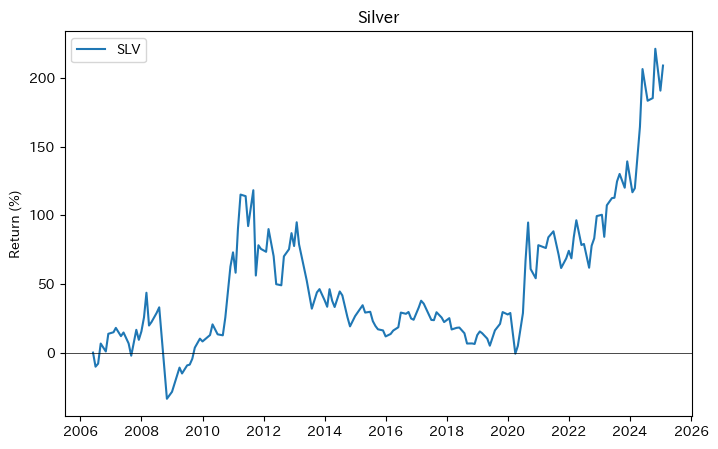

In [23]:
log_return = silver['value'].log() - silver['value'].log()[0]
silver_return = (log_return.exp() - 1) * 100

fig, ax = plt.subplots(figsize=(1.618*5, 5))
ax.plot(silver['date'], silver_return, label='SLV')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('Silver')
ax.set_ylabel('Return (%)')
ax.legend()

## Portfolio

In [99]:
tickers = yf.Tickers('GLD SLV JPY=X')
history = tickers.history(period='max', interval='1d')
df = pl.DataFrame({
    'date': history.index,
    'gold': history['Close']['GLD'] * history['Close']['JPY=X'],
    'silver': history['Close']['SLV'] * history['Close']['JPY=X']
}).with_columns(
    pl.col('date').cast(pl.Date)
).drop_nulls()

month_end = df['date'].dt.month_end().unique()
df = df.filter(pl.col('date').is_in(month_end))

df = df.with_columns(
    (((df['gold'].log() - df['gold'].log()[0]).exp() - 1) * 100).alias('gold_return'),
    (((df['silver'].log() - df['silver'].log()[0]).exp() - 1) * 100).alias('silver_return')
)

df.head()

[*********************100%***********************]  3 of 3 completed


date,gold,silver,gold_return,silver_return
date,f64,f64,f64,f64
2006-05-31,7227.802199,1421.028854,0.0,0.0
2006-06-30,7010.222517,1275.304079,-3.010316,-10.254878
2006-07-31,7232.451717,1307.13167,0.064328,-8.015121
2006-08-31,7310.354545,1514.882887,1.14215,6.604654
2006-10-31,7035.429851,1432.77969,-2.661561,0.826925


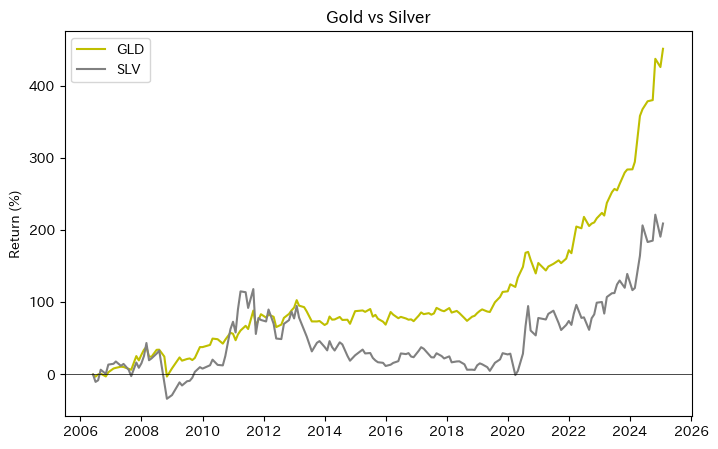

In [124]:
fig, ax = plt.subplots(figsize=(1.618*5, 5))
ax.plot(df['date'], df['gold_return'], label='GLD', color='y')
ax.plot(df['date'], df['silver_return'], label='SLV', color='gray')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('Gold vs Silver')
ax.set_ylabel('Return (%)')
ax.legend()

In [101]:
corr = np.corrcoef(df['gold_return'], df['silver_return'])[0, 1]
print(f'Correlation: {corr:.2f}')

Correlation: 0.86


In [102]:
# weights = np.array([0.5, 0.5])
sum_inv_vol = 1 / gold_vol + 1 / silver_vol
weights = np.array([1 / gold_vol / sum_inv_vol, 1 / silver_vol / sum_inv_vol])
print(f'Portfolio Weights: {weights}')
weights = np.array([0.95, 0.05])

mu_i = np.array([gold_cagr, silver_cagr])
mu_p = weights @ mu_i
print(f'Portfolio CAGR: {mu_p:.2%}')

tmp = np.array([
    df['gold'].log().diff().drop_nulls(),
    df['silver'].log().diff().drop_nulls()
])
Sigma = np.cov(tmp)
sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f'Portfolio Volatility: {sigma_p:.2%}')

print(f'Portfolio Sharp Ratio: {(mu_p / sigma_p):.2f}')

Portfolio Weights: [0.66190683 0.33809317]
Portfolio CAGR: 15.72%
Portfolio Volatility: 17.61%
Portfolio Sharp Ratio: 0.89


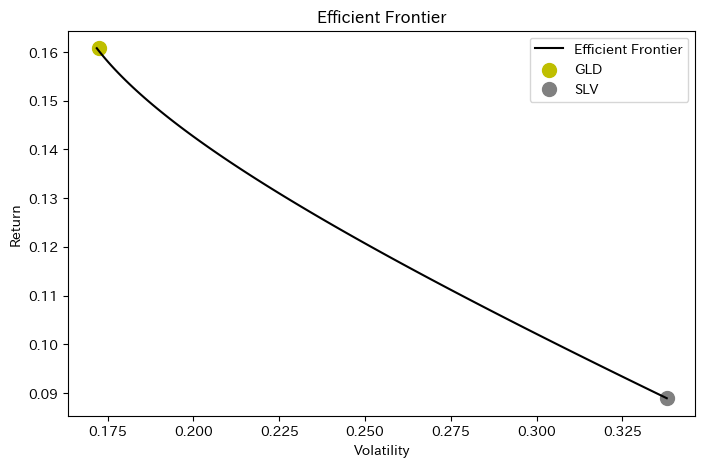

In [125]:
# Efficient Frontier
weights_list = [
    np.array([w, 1-w]) for w in np.linspace(0, 1, 100)
]
mu_list = [w @ mu_i for w in weights_list]
sigma_list = [np.sqrt(w @ Sigma @ w) * np.sqrt(12) for w in weights_list]
efficient_frontier = pl.DataFrame({
    'weights': weights_list,
    'mu': mu_list,
    'sigma': sigma_list
})

fig, ax = plt.subplots(figsize=(1.618*5, 5))
ax.plot(sigma_list, mu_list, color='black', label='Efficient Frontier')
ax.scatter(gold_vol, gold_cagr, color='y', label='GLD', s=100)
ax.scatter(silver_vol, silver_cagr, color='gray', label='SLV', s=100)
ax.scatter
ax.set_title('Efficient Frontier')
ax.set_xlabel('Volatility')
ax.set_ylabel('Return')
ax.legend()


## 相関のチェック

In [88]:
df = df.with_columns(
    pl.Series(np.linspace(1, len(df), len(df)).astype(int)).alias('time_trend'),
    pl.col('gold').log().diff().alias('gold_diff'),
    pl.col('silver').log().diff().alias('silver_diff')
)

y, X = dmatrices(
    'gold_diff ~ silver_diff + time_trend',
    data=df.to_pandas(),
    return_type='dataframe'
)

model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              gold_diff   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     95.18
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           1.08e-27
Time:                        05:20:49   Log-Likelihood:                 314.18
No. Observations:                 158   AIC:                            -622.4
Df Residuals:                     155   BIC:                            -613.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0033      0.005      0.611      

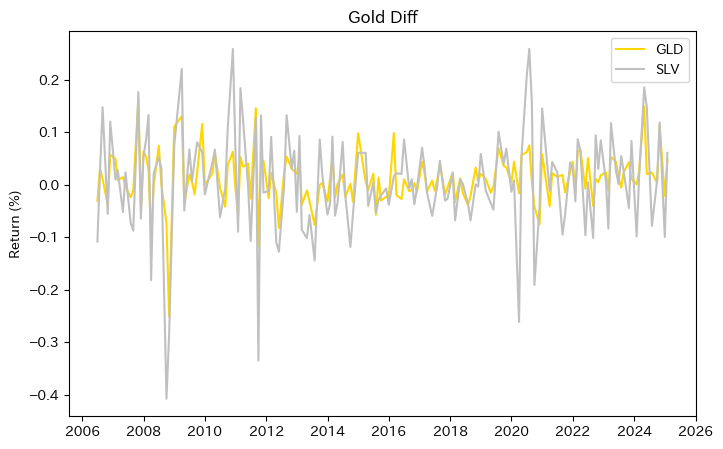

In [91]:
fig, ax = plt.subplots(figsize=(1.618*5, 5))
ax.plot(df['date'], df['gold_diff'], label='GLD', color='gold')
ax.plot(df['date'], df['silver_diff'], label='SLV', color='silver')
ax.set_title('Gold Diff')
ax.set_ylabel('Return (%)')
ax.legend()
